In [1]:
from ekpy import analysis
import numpy as np
import scipy.integrate as it
from scipy.signal import find_peaks, savgol_filter, peak_widths
import matplotlib.pyplot as plt

In [2]:
# load the dataset
dset = analysis.load_Dataset('./newsampleworksradiant')

# print dset, parsable collection of meta data which holds pointers to the real data files
dset

,initial_delay,pulse_delay,freq,voltage,capacitor_area,thickness,permittivity,amplification,format,type,points,count,x_increment,x_origin,x_reference,y_increment,y_origin,y_reference,trial,filename
0,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__0.csv
1,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__1.csv
2,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__2.csv
3,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__3.csv
4,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__4.csv
5,0.00005,0.000005,10,1,4.000000e-08,1.000000e-08,30,8,0,0,995,1,4.720000e-07,2.710505e-20,0,0.01005,0.0,0,0,fe_pv__5.csv


In [3]:
data = dset.get_data()

In [4]:
type(data)

ekpy.analysis.core.Data

In [ ]:
data2 = dset.query("voltage == 1").get_data()

In [3]:
data2 = dset.select_index(0).get_data()

In [ ]:
data2.summary

In [ ]:
data2.data_keys

In [ ]:
data2.plot(x='time_v', y='wfm_v')

In [ ]:
data2.plot(x='time_c', y='wfm_c')

use data.definition (no parenthesis) to get all the meta data associated with the exp for all trials in the dset

We may need to normalize the data for the wfm c to 0, aka shift it correspondingly. not sure why since it should be doing that but I will have to think about it

In [ ]:
type(data2) #this is already a numpy array lets fucking gooo

In [ ]:
data['time_v']

In [ ]:
data.iloc[0].plot(x='time_v', y='wfm_v')

In [ ]:
data.plot()

In [ ]:
def generate_q_wfm(data_dict) -> 'dict':
    wfm_q = it.cumulative_trapezoid(data_dict['wfm_c'], data_dict['time_c'], initial=0) 
    data_dict['wfm_q'] = wfm_q
    return data_dict

In [ ]:
def generate_q_wfm_wrong(data_dict) -> 'dict':
    wfm_q = it.cumulative_trapezoid(data_dict['wfm_v'], data_dict['time_v'], initial=0) 
    data_dict['wfm_q_wrong'] = wfm_q
    return data_dict

In [ ]:
def drift_correct_q(data_dict)-> 'dict':
    slope = (data_dict['wfm_q'][-1] - data_dict['wfm_q'][0])/(data_dict['time_c'][-1] - data_dict['time_c'][0])
    wfm_q_drift_corrected = []
    for i in range(len(data_dict['wfm_q'])):
        wfm_q_drift_corrected.append(data_dict['wfm_q'][i]-(slope*data_dict['time_c'][i]))
    data_dict['wfm_q'] = wfm_q_drift_corrected
    return data_dict


In [ ]:
newwwwww = data2.apply(generate_q_wfm)

In [ ]:
newwwwww.plot(x='time_c', y='wfm_q') #IT WORKS!!

In [ ]:
newwwwww2 = newwwwww.apply(drift_correct_q)

In [ ]:
newwwwww2.plot(x='time_c', y='wfm_q')

In [ ]:
wrong = data2.apply(generate_q_wfm_wrong)

In [ ]:
wrong.plot(x='time_v', y='wfm_q_wrong')

Now we need to convert this to polarization plot vs voltage. We are using the derivative of the waveform to essentially find out when the wavefoprm starts and ends
1. First take derivative of wfm
2. Then find points where it starts

In [ ]:
def derivative(data_dict)->'dict':
    wfm_int = np.gradient(data_dict['wfm_v'], data_dict['time_v'])
    #add smoothing?
    wfm_int_smooth = savgol_filter(wfm_int, 51, 3)
    #normalize values to 1
    wfm_int_smooth_norm =  2 * ((wfm_int_smooth - np.min(wfm_int_smooth)) / (np.max(wfm_int_smooth) - np.min(wfm_int_smooth))) - 1
    data_dict['wfm_int'] = wfm_int_smooth_norm
    return data_dict

In [ ]:
wrong2 = wrong.apply(derivative) #bruh why did i call it wfm_int its not an integral lmfaooo, wrong 2 is useless in the grandscheme of things

In [ ]:
wrong2.plot(x='time_v', y='wfm_int')

MAKE A FUNCTION CALLED VISUALIZE ANALYSIS THAT DOES EACH STEP OF THE PROCESS AND PLOTS SEQUENTIALLY WITH APPROPIATE CAPTIONS (TITLES)

NEW METHOD, USE FINDPEAKS AND FINDTROUGHS (FIND PEAKS OF INVERTED DATASET) AND THAT IS EQUAL TO HALF OF THE TOTAL PULSE LENGTH AND JUST USE THAT TO FIND THE START AND END!

In [ ]:
def find_peaks_troughs_index(data_dict)->'dict':
    arr = data_dict['wfm_v']
    arr_normalized = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    peaks, _ = find_peaks(arr_normalized, height=0.8)
    troughs, _ = find_peaks(-1*arr_normalized, height=0.8)
    all_peaks = np.concatenate((peaks, troughs), axis=0)
    #results_full = peak_widths(arr_normalized, peaks, rel_height=1)
    #data_dict['results_full'] = results_full
    data_dict['peaks'] = np.sort(all_peaks)
    return data_dict
    

In [ ]:
wrong3 = wrong2.apply(find_peaks_troughs_index)

In [ ]:
#changing this here
wrong3 = newwwwww2.apply(find_peaks_troughs_index)

In [ ]:
wrong3['peaks']

In [ ]:
wrong3.plot(x='time_v', y='wfm_v')

In [ ]:
def start_and_end_pulse(data_dict)->'dict':
    x = data_dict['peaks']
    counter = 0
    green_points = []
    while counter <(len(x)):
        half_pulse_len = x[counter+1] - x[counter]
        quarter_pulse_len = half_pulse_len/2
        start_of_pulse = x[counter] - quarter_pulse_len
        end_of_pulse = x[counter+1] + quarter_pulse_len
        green_points.append(int(start_of_pulse))
        green_points.append(int(end_of_pulse))
        counter +=2
    data_dict['start_and_end_pulse'] = green_points
    return data_dict
    

In [ ]:
wrong4 = wrong3.apply(start_and_end_pulse)

In [ ]:
wrong4['start_and_end_pulse']

In [ ]:
wrong4.data_keys

In [ ]:
x = wrong3['peaks']
print(x)
green_points = []
counter = 0
while counter <(len(x)):
    half_pulse_len = x[counter+1] - x[counter]
    quarter_pulse_len = half_pulse_len/2
    start_of_pulse = x[counter] - quarter_pulse_len
    end_of_pulse = x[counter+1] + quarter_pulse_len
    green_points.append(int(start_of_pulse))
    green_points.append(int(end_of_pulse))
    counter +=2
print(green_points)
#witdthss = wrong3['results_full']
#widthsfixed = (np.array([109.5, 222. , 222. , 108. ]), np.array([-0.02020202, -1.        , -1.        , -0.01010101]), np.array([103., 265., 604., 879.]), np.array([212.5, 487. , 826. , 987. ]))
plt.scatter(wrong3['time_v'][x], wrong3['wfm_v'][x], color='red') #need to use a hieght
#plt.hlines(*widthsfixed[1:], color='C2')
plt.scatter(wrong3['time_v'][green_points], wrong3['wfm_v'][green_points], color='green')
plt.plot(wrong3['time_v'], wrong3['wfm_v'])

In [ ]:
plt.plot(wrong3['time_v'][green_points[0]:green_points[1]+1], wrong3['wfm_v'][green_points[0]:green_points[1]+1])

In [ ]:
wrong4.data_keys

In [ ]:
x1 = wrong4['wfm_v'][wrong4['start_and_end_pulse'][0]:wrong4['start_and_end_pulse'][1]+1]
y1 = wrong4['wfm_q'][wrong4['start_and_end_pulse'][0]:wrong4['start_and_end_pulse'][1]+1]

In [ ]:
plt.plot(x1,y1)

In [ ]:
x2 = wrong4['wfm_v'][wrong4['start_and_end_pulse'][2]:wrong4['start_and_end_pulse'][3]+1]
y2 = wrong4['wfm_q_wrong'][wrong4['start_and_end_pulse'][2]:wrong4['start_and_end_pulse'][3]+1]

In [ ]:
plt.plot(x2,y2)

In [91]:
my_str = """
    Adds 'wfm_q' to the given data_dict by integrating over the given waveform.

    Requirements
    ------------
    wfm_c: dict key 
        The data_dict key containing the current wf
    time_c: dict key
        The data_dict key containing the time wf
    Returns
    -------
    data_dict: dict
        The mutated dictionary with the q_wfm added.
    PLOT_AGAINST: time_c
    MODIFIES: wfm_q"""

In [66]:
my_sr = 'he'
my_sr.find('g')

-1

In [ ]:
print(data2.data_keys)
print(wrong.data_keys)
print(wrong2.data_keys)
print(wrong3.data_keys)
print(wrong4.data_keys)

In [ ]:
wrong4.to_ekpdat('./test69') #saves data when ur working, good to know to add lmao

In [4]:
"""
Here I will make a helper funciton that takes in a doc string and returns what funciton it appends based on the format
"""

def get_function_doc_append(doc_string):
    """
    Helper function which takes in an appropiately formatted string and scans it for the appended value. See use_analysis_file for more
    information

    Args:
        doc_string (str): The given doc_string to scan
    Returns:
        func_name_appended (str): The name of the function that was modified by the function
        plotted_against (str): The key that should be plotted against whatever was modified here, Returns None if not found
    """
    ending_index_of_match = doc_string.find("MODIFIES:") + len("MODIFIES:")
    func_name_appended = doc_string[ending_index_of_match:].strip()
    if doc_string.find("PLOT_AGAINST:") != -1:
        plotted_against_start = doc_string.find("PLOT_AGAINST:") + len("PLOT_AGAINST:")
        plotted_against_end = doc_string[plotted_against_start:].find("\n")
        plotted_against = doc_string[plotted_against_start:plotted_against_start+plotted_against_end].strip()
    else:
        plotted_against = None
    return func_name_appended, plotted_against
    

In [92]:
g,h = get_function_doc_append(my_str)

In [93]:
h

'time_c'

In [47]:
skip_func = 'hello'
my_func_list = ['hello', 'yes']
if skip_func is not list:
    t = []
    t.append(skip_func)
    skip_func = t
print(skip_func)
for func in skip_func:
    my_func_list.remove(func)
my_func_list

['hello']


['yes']

In [31]:
"""
This function is now the function that can recover the Dataset to spit out verbose at all intermediate steps

what would make sense, lets say you want to get a specific data in the file, can pass function list?
SIKE this is now a helper function that helps plot things verbose given the correct data, and thus we can use it both for when recovering data for verbose
or when we use the analysis file with verbose set to true

should be able to do verbose even if saveall is not true

IF PLOT_AGAINST is missing we assume that it is indices if the length is not the same as the data[0]

"""
from ekpy.analysis.plotting import lane_martin
import matplotlib.pyplot as plt
def verbose_helper(data_saver, funcs_modified, plotted_against):
    """
    Helper Function that takes in a dictionary of ekpds.Data and a list of functions that were modified and plots each one in accordance to
    specificaions

    Args:
        data_saver (dict): A dictionary of each intermediate step in the process
        funcs_modified (list): A list of what was modified each time in the process
        x_key (str): The key of what we want to plot everything against (the x axis)
    Returns:
        None
    """
    scatter = False
    data_saver_list = list(data_saver.keys())
    for i, name in enumerate(data_saver_list):
        data = data_saver[name] #we get the data starting with data0 the original data
        func_modified = funcs_modified[i]
        if func_modified == 'original':
            func_modified = data.data_keys[1]
        plot_against = plotted_against[i]
        if plot_against is None:
            plot_against = data.data_keys[0] #plots first element

        #check to make sure that the plot_against is the same length as func_modifed
        if len(data[func_modified]) != len(data[plot_against]):
            indices = np.array(data[func_modified])
            plot_against = data.data_keys[0]
            func_modified = data.data_keys[1]
            x_scatter = data[plot_against][indices] #this assumes that func_modified is a list of integers
            y_scatter = data[func_modified][indices]
            scatter = True

        #Setup plt ax and style
        plt.style.use(lane_martin)
        fig, ax = plt.subplots()
        if scatter:
            ax.scatter(x=x_scatter, y=y_scatter)

        ax.set_title(f'Function Applied: {funcs_modified[i]}')
        ax.set_xlabel(plot_against)
        ax.set_ylabel(func_modified)
        data.plot(x=plot_against, y=func_modified, ax=ax, labelby='trial')



In [6]:
from inspect import getmembers, isfunction, getdoc
from importlib import import_module
from ekpy.analysis.core import Data, Dataset
import os
import pandas as pd
def use_analysis_file(module, data, saveall=False, path=None, skip_func=None):
    """
    Reads correctly formatted analysis file and performs all functions in sequential order and returns the final mutated Data. Only want it to return the final
    mutated data alongside the original unless saveall=True

    So because of overriding cases where a func overrides something by say data_dict['voltage'] = new_voltage but data_dict['voltage'] already existed we
    have data saver to save the day!

    Args:
        module (str): the name of the analysis file which must be in the same directory.
        data (ekpy.data): The data to use the analysis file on.
        saveall (Boolean): If set to true it saves each intermediate step to a file
        path (str): if savell is true you must set a path where to save the intermediate steps. Usually the path where you pulled the dset from.
        skip_func (str or list of str): The name of the functions to list, if skip_func is not defined in the analysis file it is simply not skipped and
        a warning appears

    Returns:
        data (ekpy.data): The modified data.
        data_saver (dict): A Dictionary containing all the intermediate steps of the data. (optional)
    """
    module = import_module(module)
    functions_list = list(module.__all__)
    if skip_func is not None:
        if skip_func is not list:
            t = []
            t.append(skip_func)
            skip_func = t
        for func in skip_func:
            try:
                functions_list.remove(func)
            except ValueError:
                print('Did not skip as skip_func does not exist, perhaps the spelling is wrong')
    data_saver = {'data0': data,}
    funcs_modified = ['original',]
    plotted_against_list = [None, ]
    for i, name in enumerate(functions_list):
        func = getattr(module, name)
        func_doc_str = getdoc(func)
        func_appended, plotted_against = get_function_doc_append(func_doc_str)
        funcs_modified.append(func_appended)
        plotted_against_list.append(plotted_against)
        key_name = f"data{i + 1}"
        data_saver[key_name] = data.apply(func)
        data = data_saver[key_name]
    original_data = data_saver['data0'].to_dict()
    last_data_added = data[data.data_keys[-1]]
    original_data[0]['data'][data.data_keys[-1]] = last_data_added
    data_out = Data(original_data)

    verbose_helper(data_saver, funcs_modified, plotted_against_list)

    if saveall:
        if path is None:
            print("Warning creating a directory since a path was not given")
            path = './'
        path = path + '/data_saver0'
        iterator = 1
        while os.path.exists(path):
            if iterator > 1000:
                raise ValueError("Dog make a new directory. you have over 1000 folders here or something messed up")
            path = list(path)
            path[-1] = str(iterator)
            path = "".join(path)
            iterator += 1
        os.mkdir(path)
        print("Folder %s created!" % path)
        meta_data_saver = Data({0: {'definition':0, 'data': {'funcs_modified': np.array(funcs_modified, dtype=str), 'plotted_against': np.array(plotted_against_list)}}})
        meta_data_saver.to_ekpdat(path + '/saver.ekpdat')
        for keys in data_saver:
            data_saver[keys].to_ekpdat(path +f'\\{keys}'+'.ekpdat')
        return data_out, data_saver
    else:
        return data_out, None

In [12]:
data2.data_keys[0]


'time_v'

In [ ]:
t_meta_data = pd.DataFrame({'funcs_modified':np.array(['original', 'wfm_q', 'wfm_q_wrong']), 
                            'filename':['data0.expdat', 'data1.expdat', 'data2.expdat']})

dsetg = Dataset('./testnew/data_saver3', t_meta_data)

In [ ]:
from ekpy.analysis.load import read_ekpdat, read_ekpds

In [9]:
data2.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c', 'start_and_end_pulse']

In [ ]:
dsetg.to_ekpds('./testnew/data_saver3/meta_data')

In [ ]:
haggy = analysis.load_Dataset('./testnew/data_saver3')

In [ ]:
backsup = read_ekpds('testnew/data_saver3/dset1.ekpds')

In [ ]:
backsup['funcs_modified']

In [ ]:
data3 = data2.to_dict()

In [ ]:
data3[0]['data'].keys()

In [ ]:
data2.to_ekpdat('testnew/yay') #saves modifed data_file

Did not skip as skip_func does not exist, perhaps the spelling is wrong


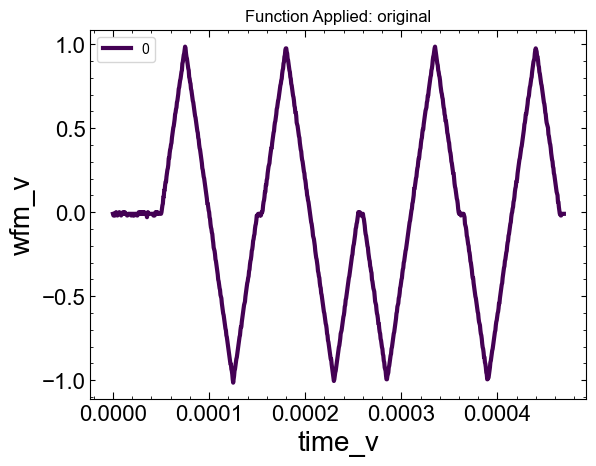

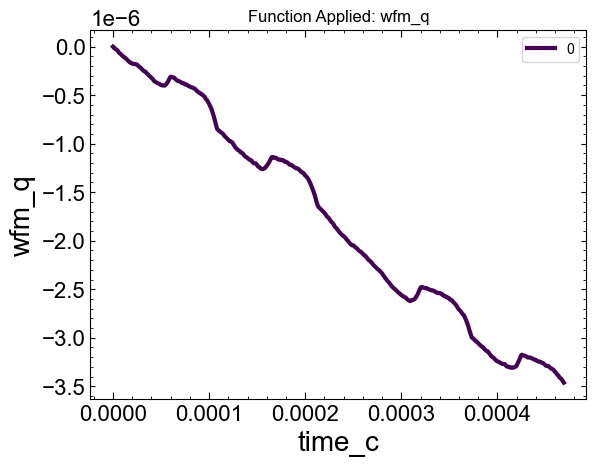

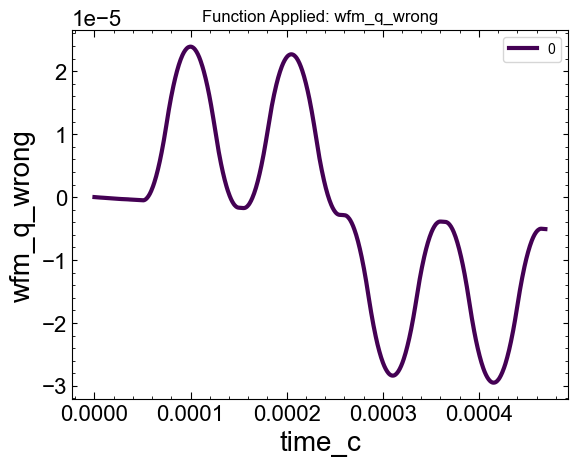

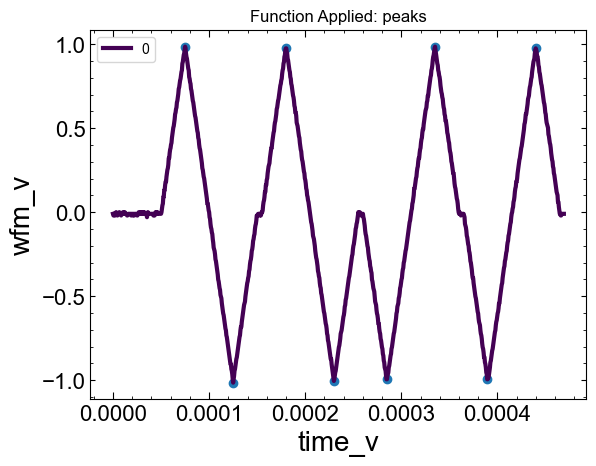

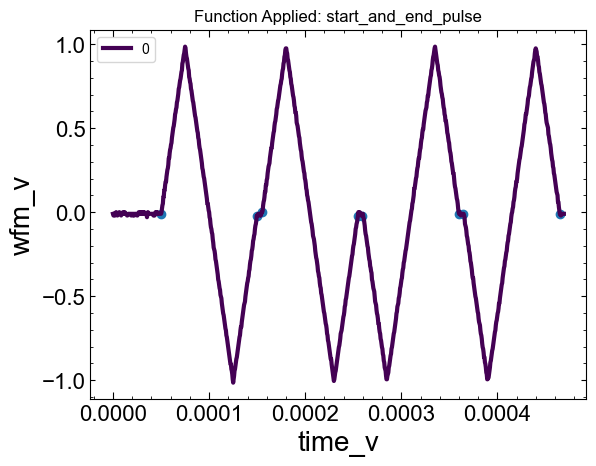

In [32]:
betee, backup = use_analysis_file('analysisfile', data2, False, './testnew', skip_func='g')

None


In [81]:
betee.data_keys

['time_v', 'wfm_v', 'time_c', 'wfm_c', 'wfm_q_wrong', 'wfm_q']

In [84]:
betee, backup = use_analysis_file('analysisfile', data2, True, './testnew')

Folder ./testnew/data_saver9 created!


In [ ]:
backup

In [ ]:
recovery = analysis.load_Dataset('./testnew/data_saver2')

In [88]:
gurrr = read_ekpdat('./testnew/data_saver9/saver.ekpdat')

In [89]:
gurrr

{0: {'data': {'funcs_modified': array(['original', 'wfm_q', 'wfm_q_wrong'], dtype='<U11'),
              'plotted_against': array([None, None, None], dtype=object)},
     'definition': 0}}

In [37]:
gurrr.data['funcs_modified'] #THIS IS HOW U CAN READ OUT THE FUNCTIONS THAT WERE USED

array(['original', 'wfm_q', 'wfm_q_wrong'], dtype='<U11')

GOAL FOR NEXT TIME, WHEN WE GET THE PATH TO WHERE WE WANT TO RECOVER OUR MODIFIED DATA FROM CAN USE OS.LISTDIR
THEN MATCH THE 0 INDEX TO THE 0 INDEX OF GURRR.DATA['FUNCS_MODIFIED][0] AND 1 TO 1 AND SO FORTH

In [ ]:
recovery

In [ ]:
recovery.get_data()

In [ ]:
read_ekpds

In [ ]:
yesssy.data_keys

In [ ]:
betee.data_keys

In [ ]:
bbb = list(backup) #can use list to just get the keys as a list

In [ ]:
print(bbb)

In [ ]:
backup['data0'].data_keys

In [ ]:
backup['data1'].data_keys

In [ ]:
data2.data_keys

In [ ]:
functions_list = getmembers(analysisfile, isfunction)

In [ ]:
functions_list